https://wandb.ai/ml43d/3dpart-simclr/runs/21070614442839/files/3dpart-simclr/21070614442839/checkpoints

In [1]:
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 
os.chdir('..')

In [12]:
import time
import torch
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader

%matplotlib inline
import matplotlib.pyplot as plt

from datasets.shapenet_parts.shapenet_parts import ShapeNetParts
from datasets.data_modules import PartSegmentationDataModule

from models.pointnet import PointNetSegmentation
from pointnet_module import SupervisedPointNet

Load the model with saved weights

In [3]:
batch_size = 8
limit_ratio = 0.8

dm = PartSegmentationDataModule(batch_size,limit_ratio=limit_ratio)
seg_class_map = dm.seg_class_map
num_seg_classes = dm.num_seg_classes
num_classes = dm.num_classes
train_dataloader = dm.train_dataloader()

plmodel = SupervisedPointNet(gpus=1,batch_size=batch_size,seg_class_map=seg_class_map)
plmodel = plmodel.load_from_checkpoint(checkpoint_path="./checkpoints/epoch=99-step=75799.ckpt")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
plmodel = plmodel.to(device)

cuda:0


In [5]:
num_features = 2048
z_y = np.zeros((len(train_dataloader)*batch_size,num_features+1))

quick_load = True
if not quick_load:
    plmodel.eval()
    encoder = plmodel.model.encoder
    with torch.no_grad():
        i = 0
        for batch_index,batch in enumerate(train_dataloader):
            x,_,cls_id = batch
            x = x.to(device)
            cls_id = cls_id.to(device)
            out_max,concat,trans_feat = encoder(x)
            end = i + batch_size
            z_y[i:end] = torch.cat((out_max.detach().cpu(),cls_id.detach().cpu().unsqueeze(1)),1)
            i = end
    print(z_y.shape)
    with open('z_y.npy', 'wb') as f:
        np.save(f, z_y)
else:
    z_y = np.load('z_y.npy')

(9704, 2049)


In [10]:
pca = PCA(n_components=2)
print(z_y[:,:-1].shape)
pca_result = pca.fit_transform(z_y[:,:-1])
pca_1 = pca_result[:,0]
pca_2 = pca_result[:,1]

(9704, 2048)
Explained variation per principal component: [0.14539247 0.13464906]


In [13]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=5000)
tsne_results = tsne.fit_transform(z_y[:,:-1])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 9704 samples in 1.677s...
[t-SNE] Computed neighbors for 9704 samples in 462.332s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9704
[t-SNE] Computed conditional probabilities for sample 2000 / 9704
[t-SNE] Computed conditional probabilities for sample 3000 / 9704
[t-SNE] Computed conditional probabilities for sample 4000 / 9704
[t-SNE] Computed conditional probabilities for sample 5000 / 9704
[t-SNE] Computed conditional probabilities for sample 6000 / 9704
[t-SNE] Computed conditional probabilities for sample 7000 / 9704
[t-SNE] Computed conditional probabilities for sample 8000 / 9704
[t-SNE] Computed conditional probabilities for sample 9000 / 9704
[t-SNE] Computed conditional probabilities for sample 9704 / 9704
[t-SNE] Mean sigma: 3.726730
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.659927
[t-SNE] KL divergence after 750 iterations: 1.003423
t-SNE done! Time elapsed: 580.677932

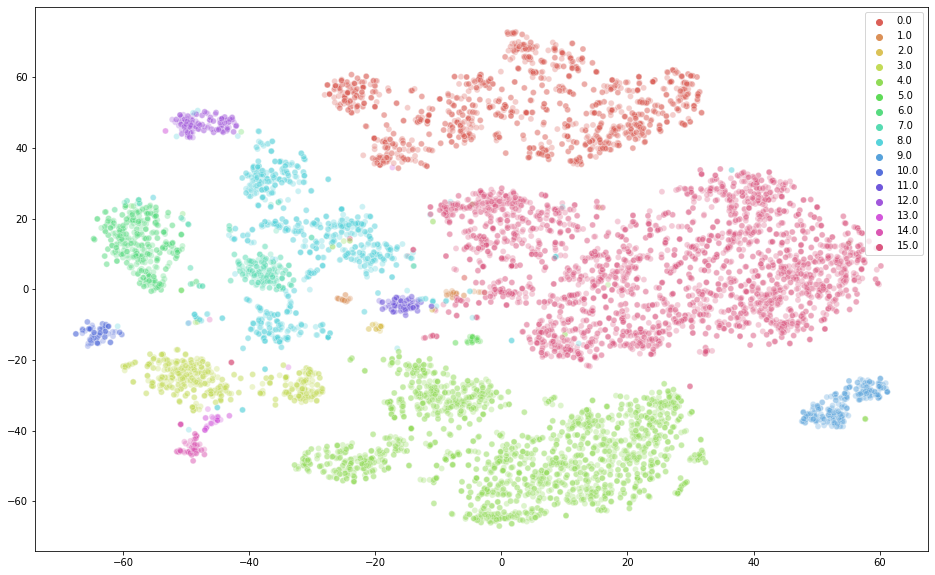

In [16]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=z_y[:,-1],
    palette=sns.color_palette("hls", num_classes),
    legend="full",
    alpha=0.3
)